In [1]:
from tensorflow import keras as kf
import matplotlib.pyplot as plt
from CODE.utils import *


In [78]:
def create_2f_model(n_units, input_shape, file=None):
    window_size, input_dim = input_shape
    input_1 = kf.layers.Input(shape=(window_size, input_dim-1))
    input_2 = kf.layers.Input(shape=(window_size - 1, 1))

    # lstm_1= kf.layers.LSTM(n_units, return_state=True)
    # output,  output_h, output_c = lstm_1(input_1)

    lstm_1 = kf.layers.Bidirectional(kf.layers.LSTM(n_units, return_state=True))
    _,  output_h1, output_c1, output_h2, output_c2 = lstm_1(input_1)
    output_h =  kf.layers.Concatenate()([output_h1,output_h2])
    output_c =  kf.layers.Concatenate()([output_c1,output_c2])
    
    dense_h = kf.layers.Dense(n_units)(output_h)
    dense_C = kf.layers.Dense(n_units)(output_c)
    
    encoder_states = [dense_h, dense_C]

    lstm_2 = kf.layers.LSTM(n_units)
    lstm_out = lstm_2(input_2, initial_state=encoder_states)

    dense_in = kf.layers.Dense(n_units//2,activation='tanh')(lstm_out)
    dense_out = kf.layers.Dense(1, activation='linear', use_bias=False)(dense_in)

    model = kf.models.Model(inputs=[input_1, input_2], outputs=[dense_out])
    model.compile(optimizer='rmsprop', loss='mse')

    if file == file:
        try:
            model.load_weights(file)
        except:
            pass
    return model

In [90]:

window_size = 5
n_units = 512

df = load_dfs()

diff_df = df.pct_change(1).iloc[1:,:]
X1, X2, Y = generate_windows_for_two_factor(diff_df, window_size)

file = 'FILES/Models/lstm_2f_model.hdf5'
input_shape = (window_size,df.values.shape[1])
model = create_2f_model(n_units, input_shape, file)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 5, 22)        0                                            
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional [(None, 1024), (None 2191360     input_25[0][0]                   
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 1024)         0           bidirectional_11[0][1]           
                                                                 bidirectional_11[0][3]           
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 1024)         0           bidirectional_11[0][2]           
          

In [80]:

epochs = 100
for i in range(epochs):
    hist = model.fit(x=[X1, X2],
              y=Y,
              batch_size=512,
              verbose=0,
              epochs=1,
              validation_split=0.05,
              callbacks=[])
    if i > 0:
        if hist.history['val_loss'][-1] < val_loss:
            val_loss = hist.history['val_loss'][-1]
            print("New best val_loss: {}\t epoch: {}".format(val_loss,i))
            model.save_weights(file)
    else:
        val_loss =  hist.history['val_loss'][-1]


New val_loss: 0.0003892001695930958	 epoch: 1


New val_loss: 0.00033372826874256134	 epoch: 11


New val_loss: 0.0003035622648894787	 epoch: 13


New val_loss: 0.0002949649060610682	 epoch: 18


KeyboardInterrupt: 

In [81]:

start = 100
window = 100
test_df = df.iloc[0:300,0].to_frame()
test_df.columns=['Actual']
test_df['Interp'] = test_df.iloc[:,0]
test_df['Interp'].iloc[start:start+window]=np.nan
test_df = test_df.interpolate()
start_value = test_df.iloc[start-1,0]
end_value = test_df.iloc[start+window,0]

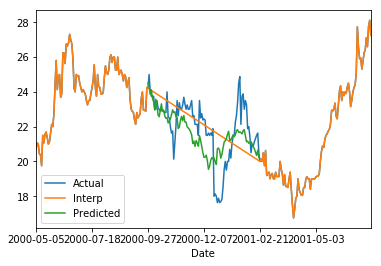

In [84]:
Y_pred, Y_actual=list(), list()
for id in range(start, start+window):
    if id == start:
        x2 = X2[id].reshape(-1, window_size - 1, 1)
    x1 = X1[id].reshape(-1,window_size,input_shape[1]-1)
    Y_pred.append(model.predict([x1, x2]).flatten())
    Y_actual.append(Y[id].flatten())
    x2[0, :-1, 0] = x2[0, 1:, 0]
    x2[0,-1,0] = Y_pred[-1]

test_df['Predicted']=np.nan
fixed_values = np.array(Y_pred)+1
for i, value in enumerate(fixed_values):
    if i == 0:
        fixed_values[0]=value*start_value
    else:
        fixed_values[i]=fixed_values[i-1]*value
multiplier = end_value/fixed_values[-1]
singlemultipliers = np.array([multiplier**(x/(window+1)) for x in range(window+2)])
test_df['Predicted'].iloc[start:start+100]=fixed_values[:, 0]*singlemultipliers[:-2, 0]
test_df.plot()


In [86]:
import matplotlib.pyplot as plt
compare_df = test_df.dropna().copy()
compare_df['LinInterpDiffs']=abs(compare_df['Actual']-compare_df['Interp'])/compare_df['Actual']
compare_df['LstmInterpDiffs']=abs(compare_df['Actual']-compare_df['Predicted'])/compare_df['Actual']
print(compare_df.head())

            Actual     Interp  Predicted  LinInterpDiffs  LstmInterpDiffs
Date                                                                     
2000-09-27   24.25  24.207921  24.510386        0.001735         0.010738
2000-09-28   25.00  24.165842  24.368914        0.033366         0.025243
2000-09-29   24.00  24.123762  23.858994        0.005157         0.005875
2000-10-02   23.75  24.081683  24.119864        0.013966         0.015573
2000-10-03   23.75  24.039604  23.628468        0.012194         0.005117


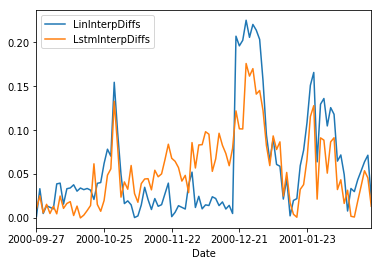

In [87]:
compare_df.iloc[:,-2:].plot()

In [88]:
print("Lstm Average Error: {}".format(compare_df['LstmInterpDiffs'].mean()))
print("Interpolation Average Error: {}".format(compare_df['LinInterpDiffs'].mean()))

Lstm Average Error: 0.05455637926096502
Interpolation Average Error: 0.05688076081949262


In [89]:
from scipy import stats

resLstm = stats.ks_2samp(compare_df['Actual'].values, compare_df['Predicted'].values)
print("Lstm KS result: \n \t - Statistic: {0} \n \t - pvalue: {1}".format(resLstm.statistic, resLstm.pvalue))
resInterp = stats.ks_2samp(compare_df['Actual'].values, compare_df['Interp'].values)
print("Interp KS result: \n \t - Statistic: {0} \n \t - pvalue: {1}".format(resInterp.statistic, resInterp.pvalue))

Lstm KS result: 
 	 - Statistic: 0.26000000000000006 
 	 - pvalue: 0.0017846674219800496
Interp KS result: 
 	 - Statistic: 0.14 
 	 - pvalue: 0.26055273160812736


<tf.Tensor 'bidirectional_6/while/Exit_3:0' shape=(?, 512) dtype=float32>